In [1]:
from experiments.mnist import *
from experiments.mnist_utils import CustomMNIST

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=10000, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=10000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10000, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args, _ = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [2]:
def main(indices_to_skip=None):
    # Turn OFF shuffling to ensure consistency
    # probably bad for performance

    train_dataset = datasets.MNIST(
        root='../data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))

    test_dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    
    # Has to be 0 and 1
    train_indices_to_keep = (train_dataset.targets == 0).bool() | (train_dataset.targets == 1).bool()
    train_dataset.data = train_dataset.data[train_indices_to_keep, ...]
    train_dataset.targets = train_dataset.targets[train_indices_to_keep, ...]
    if indices_to_skip is not None:
        for index_to_skip in indices_to_skip:
            train_dataset.data: torch.Tensor = torch.cat([
                train_dataset.data[: index_to_skip],
                train_dataset.data[index_to_skip + 1:]], dim=0)

            train_dataset.targets: torch.Tensor = torch.cat([
                train_dataset.targets[: index_to_skip],
                train_dataset.targets[index_to_skip + 1:]], dim=0)

    test_indices_to_keep = (test_dataset.targets == 0).bool() | (test_dataset.targets == 1).bool()
    test_dataset.data = test_dataset.data[test_indices_to_keep, ...]
    test_dataset.targets = test_dataset.targets[test_indices_to_keep, ...]

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=False, **kwargs)
    
    # Only work when labels are 0 and 1
    model = LogisticRegression(output_dim=1, binary=True).to(device)
    return model, train_loader, test_loader
    optimizer = optim.LBFGS(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=5, gamma=args.gamma)

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        # test(model, device, test_loader)
        scheduler.step()
    # Only do one test
    test(model, device, test_loader)

    # if args.save_model:
    #     torch.save(model.state_dict(), "mnist_cnn.pt")
    return model, train_loader, test_loader

In [3]:
%%time
model, train_loader, test_loader = main(None)
model_no_1, train_loader_no_1, test_loader_no_1 = main([11])

CPU times: user 2.18 s, sys: 1.11 s, total: 3.28 s
Wall time: 3.09 s


In [4]:
len(train_loader.dataset), len(train_loader_no_1.dataset)

(12665, 12664)

In [5]:
from tqdm import trange
def collect_all_data(data_loader, device):
    Xs = []
    Ys = []
    for x, y in data_loader:
        Xs.append(x)
        Ys.append(y)

    Xs = torch.cat(Xs, dim=0)
    Ys = torch.cat(Ys, dim=0)
    # Xs_reshaped = Xs.view(-1, 28 * 28)
    return Xs.to(device), Ys.to(device)

def train_and_test(args,
                   model,
                   device,
                   train_loader,
                   test_loader):

    test_Xs, test_Ys = collect_all_data(test_loader, device)
    train_Xs, train_Ys = collect_all_data(train_loader, device)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=300)
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=200, gamma=args.gamma)
    with trange(1, args.epochs + 1) as pbar:
        for epoch in pbar:
            loss = train_batch(model, train_Xs, train_Ys, optimizer, epoch)
            pbar.set_description(f"{loss:.5f}")
            scheduler.step()
    # Only do one test
    return test_batch(model, test_Xs, test_Ys)

In [6]:
test_losses = train_and_test(args, model, device, train_loader, test_loader)
test_no_1_losses = train_and_test(args, model_no_1, device, train_loader_no_1, test_loader_no_1)

0.00469: 100%|██████████| 10000/10000 [00:17<00:00, 573.10it/s]


Test set: Average loss: 0.0036, Accuracy: 980/2115 (46%)



0.00434: 100%|██████████| 10000/10000 [00:17<00:00, 568.76it/s]

Test set: Average loss: 0.0034, Accuracy: 980/2115 (46%)



In [7]:
# torch.save(model.state_dict(), "/export/home/Experiments/20200621/model.mnist.full.pt")
# torch.save(model_no_1.state_dict(), "/export/home/Experiments/20200621/model.mnist.1.pt")

In [8]:
from influence_utils.regression import compute_influences
influences, computed_data_dict = compute_influences(
    device=device,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    weight_decay=0.01)

influences_no_1, computed_data_dict_no_1 = compute_influences(
    device=device,
    model=model_no_1,
    train_loader=train_loader_no_1,
    test_loader=test_loader_no_1,
    weight_decay=0.01)

  0%|          | 0/2 [00:00<?, ?it/s]

Computing Hessian


  0%|          | 0/2 [00:00<?, ?it/s]

Computing Training Jacobian


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Test Jacobian


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Computing Influences


  0%|          | 0/2 [00:00<?, ?it/s]

Computing Hessian


  0%|          | 0/2 [00:00<?, ?it/s]

Computing Training Jacobian


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Test Jacobian


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Computing Influences


In [9]:
Xs, Ys = collect_all_data(train_loader, device)
Xs_reshaped = Xs.view(-1, 28 * 28).cpu()

In [10]:
logits = model(Xs.cuda())
probs = torch.sigmoid(logits).squeeze()
probs = probs.cpu()

In [11]:
estimated_hessian = computed_data_dict["H_train"]
# H = X^T diag [ pi (1 - pi) ] X
expected_hessian = (
    Xs_reshaped.T
    .mm(torch.diag_embed((1 - probs) * probs))
    .mm(Xs_reshaped)
) / probs.shape[0]

# `estimated_device` also included entries for the bias
((estimated_hessian[:-1, :-1] - expected_hessian) < 2e-7).all()

tensor(False)

In [12]:
import matplotlib.pyplot as plt

In [13]:
Js_train = computed_data_dict["Js_train"]
Js_train_no_1 = computed_data_dict_no_1["Js_train"]
H_train = computed_data_dict["H_train"]
H_train_pinv = computed_data_dict["H_train_pinv"]

Text(0.5, 1.0, '0.00958, 0.00868')

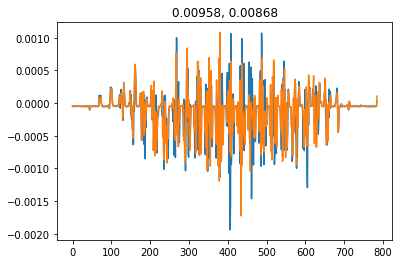

In [14]:
grad_R_train = torch.stack(Js_train, dim=0).mean(dim=0)
grad_R_train_no_1 = torch.stack(Js_train_no_1, dim=0).mean(dim=0)
actual_diff = (torch.cat([x.view(-1) for x in list(model_no_1.parameters())], dim=-1) -
               torch.cat([x.view(-1) for x in list(model.parameters())], dim=-1))

plt.plot(grad_R_train)
plt.plot(grad_R_train_no_1)
plt.title(f"{grad_R_train.norm():.5f}, {grad_R_train_no_1.norm():.5f}")

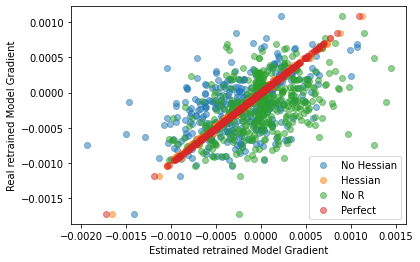

In [15]:
estimated_grad_R_train_no_1 = (grad_R_train + 1/probs.shape[0] * Js_train[1])# + H_train.mm(actual_diff.view(-1, 1).cpu()).detach().squeeze()
estimated_grad_R_train_no_1_w_H = (grad_R_train + 1/probs.shape[0] * Js_train[1]) + H_train.mm(actual_diff.view(-1, 1).cpu()).detach().squeeze()
estimated_grad_R_train_no_1_w_H_wo_R = (1/probs.shape[0] * Js_train[1]) + H_train.mm(actual_diff.view(-1, 1).cpu()).detach().squeeze()
plt.scatter(estimated_grad_R_train_no_1, grad_R_train_no_1, alpha=.5)
plt.scatter(estimated_grad_R_train_no_1_w_H, grad_R_train_no_1, alpha=.5)
plt.scatter(estimated_grad_R_train_no_1_w_H_wo_R, grad_R_train_no_1, alpha=.5)
plt.scatter(grad_R_train_no_1, grad_R_train_no_1, alpha=.5)
plt.xlabel("Estimated retrained Model Gradient")
plt.ylabel("Real retrained Model Gradient")
plt.legend(["No Hessian", "Hessian", "No R", "Perfect"])

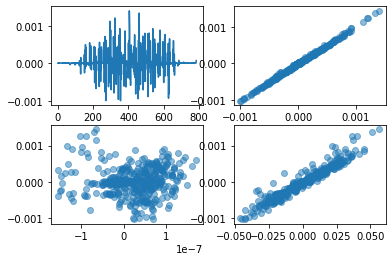

In [16]:
index_removed = 11
delta_epsilon = actual_diff.cpu().detach()
gradient_diff = grad_R_train_no_1 - grad_R_train - 1/probs.shape[0] * Js_train[index_removed]
approx_gradient_diff = - 1/probs.shape[0] * Js_train[index_removed]
scaled_parameter_diff = H_train.mm(delta_epsilon.view(-1, 1)).squeeze()

plt.subplot(221)
plt.plot(gradient_diff)
plt.subplot(222)
plt.scatter(gradient_diff, scaled_parameter_diff, alpha=0.5)
plt.subplot(223)
plt.scatter(approx_gradient_diff, scaled_parameter_diff, alpha=0.5)
plt.subplot(224)
plt.scatter(delta_epsilon, scaled_parameter_diff, alpha=0.5)
# plt.legend(["Gradient Diff", "Approx Gradient Diff", "Delta-e"])

tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)
tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)
tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)
tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)
tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)
tensor(2.8696e-07) tensor(0.0310)
tensor(0.0007) tensor(49.9108)


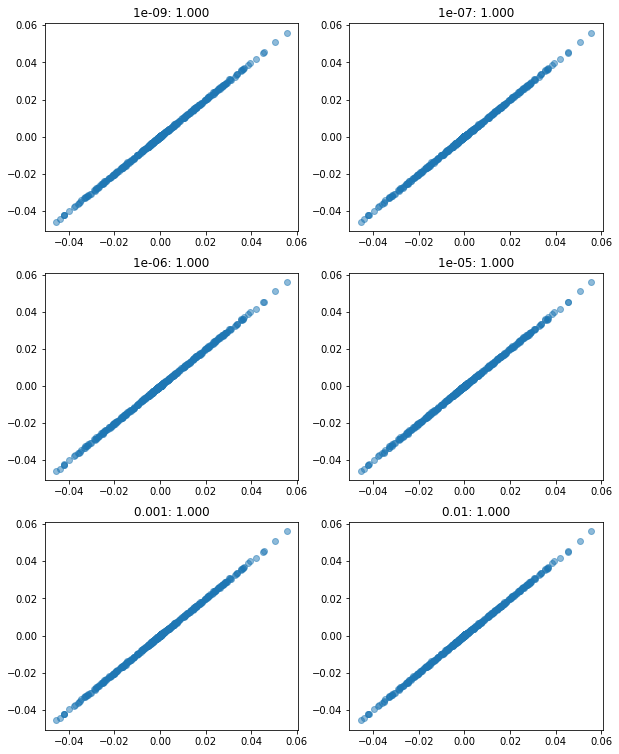

In [17]:
from scipy.stats import pearsonr
_H_train_pinv_9 = torch.pinverse(H_train, rcond=1e-9)
_H_train_pinv_7 = torch.pinverse(H_train, rcond=1e-7)
_H_train_pinv_6 = torch.pinverse(H_train, rcond=1e-6)
_H_train_pinv_5 = torch.pinverse(H_train, rcond=1e-5)
_H_train_pinv_3 = torch.pinverse(H_train, rcond=1e-3)
_H_train_pinv_2 = torch.pinverse(H_train, rcond=1e-2)
def _compute_difference(H_inv, label):
    print(torch.abs(H_train - H_train.mm(H_inv).mm(H_train)).max(), H_train.max())
    print(torch.abs(H_inv - H_inv.mm(H_train).mm(H_inv)).max(), H_inv.max())
    _predicted_diffs = H_inv.mm(
        (grad_R_train_no_1 - grad_R_train - 1/probs.shape[0] * (Js_train[index_removed])).view(-1, 1)
    ).squeeze()
    corr, _ = pearsonr(_predicted_diffs, delta_epsilon)
    plt.scatter(_predicted_diffs, delta_epsilon, alpha=0.5)
    plt.title(f"{label}: {corr:.3f}")

plt.rcParams["figure.figsize"] = (10,13)
plt.subplot(321)
_compute_difference(_H_train_pinv_9, 1e-9)
plt.subplot(322)
_compute_difference(_H_train_pinv_7, 1e-7)
plt.subplot(323)
_compute_difference(_H_train_pinv_6, 1e-6)
plt.subplot(324)
_compute_difference(_H_train_pinv_5, 1e-5)
plt.subplot(325)
_compute_difference(_H_train_pinv_3, 1e-3)
plt.subplot(326)
_compute_difference(_H_train_pinv_2, 1e-2)

In [18]:
result2 = torch.lu_solve(
    Js_train[index_removed].view(-1, 1),
    *torch.lu(H_train),
)

In [19]:
import numpy as np
from scipy.optimize import fmin_ncg
A = H_train.numpy()
Ax_fn = lambda x: (A * x).sum(-1)
b = Js_train[index_removed].numpy()

result = fmin_ncg(f=lambda x: 0.5 * np.dot(x, Ax_fn(x)) - np.dot(b, x),
                  x0=np.zeros_like(b),
                  fprime=lambda x: Ax_fn(x) - b,
                  fhess_p=lambda x, p: Ax_fn(p),
                  avextol=1e-8,
                  maxiter=256)

Optimization terminated successfully.
         Current function value: -0.002771
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 16
         Hessian evaluations: 25


In [20]:
new_predicted_diffs_no_H_weak = - (
    (1/probs.shape[0] * Js_train[index_removed])
).squeeze()

new_predicted_diffs_no_H_oracle = - (
    (-grad_R_train_no_1 + grad_R_train + 1/probs.shape[0] * (Js_train[index_removed]))
).squeeze()

new_predicted_diffs_weak = - _H_train_pinv_6.mm(
    (1/probs.shape[0] * Js_train[index_removed]).view(-1, 1)
).squeeze()

new_predicted_diffs_oracle = - _H_train_pinv_6.mm(
    (-grad_R_train_no_1 + grad_R_train + 1/probs.shape[0] * (Js_train[index_removed])).view(-1, 1)
).squeeze()

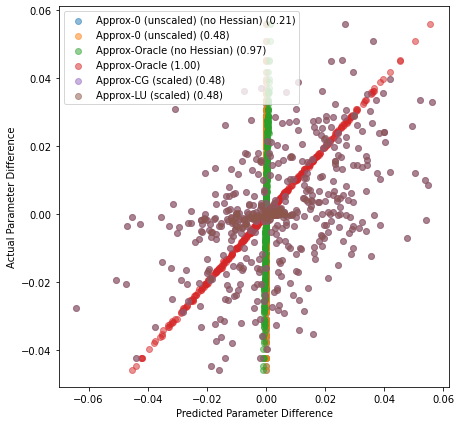

In [26]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.scatter(new_predicted_diffs_no_H_weak, actual_diff.cpu().detach(), alpha=0.5)
plt.scatter(new_predicted_diffs_weak, actual_diff.cpu().detach(), alpha=0.5)
plt.scatter(new_predicted_diffs_no_H_oracle, actual_diff.cpu().detach(), alpha=0.5)
plt.scatter(new_predicted_diffs_oracle, actual_diff.cpu().detach(), alpha=0.5)
plt.scatter(-result, actual_diff.cpu().detach(), alpha=0.5)
plt.scatter(-result2.view(-1), actual_diff.cpu().detach(), alpha=0.5)
# plt.scatter(actual_diff.cpu().detach(), actual_diff.cpu().detach(), alpha=0.15)
plt.xlabel("Predicted Parameter Difference")
plt.ylabel("Actual Parameter Difference")


def _get_pearsonr(X):
    corr, _ = pearsonr(X, actual_diff.cpu().detach())
    return corr

plt.legend([
    f"Approx-0 (unscaled) (no Hessian) ({_get_pearsonr(new_predicted_diffs_no_H_weak):.2f})",
    f"Approx-0 (unscaled) ({_get_pearsonr(new_predicted_diffs_weak):.2f})",
    f"Approx-Oracle (no Hessian) ({_get_pearsonr(new_predicted_diffs_no_H_oracle):.2f})",
    f"Approx-Oracle ({_get_pearsonr(new_predicted_diffs_oracle):.2f})",
    f"Approx-CG (scaled) ({_get_pearsonr(-result):.2f})",
    f"Approx-LU (scaled) ({_get_pearsonr(-result2.view(-1)):.2f})",
#     f"Perfect ({_get_pearsonr(-result2.view(-1)):.2f})"
])

# plt.savefig("/export/home/Experiments/20200621/fig.pdf")

In [22]:
test_losses = test(model, device, test_loader)
test_losses_no_1 = test(model_no_1, device, test_loader_no_1)
test_losses = test_losses[0]
test_losses_no_1 = test_losses_no_1[0]


Test set: Average loss: 0.0036, Accuracy: 980/2115 (46%)


Test set: Average loss: 0.0034, Accuracy: 980/2115 (46%)



In [23]:
_pred_influences = -torch.stack(computed_data_dict["Js_test"], dim=0).mm(torch.from_numpy(result)
                                                                        .view(-1, 1)).squeeze()
indices = _pred_influences.argsort()
_pred_influences[indices]
# indices = indices[-10:]

tensor([-0.0788, -0.0609, -0.0217,  ...,  0.0588,  0.1028,  0.1060])

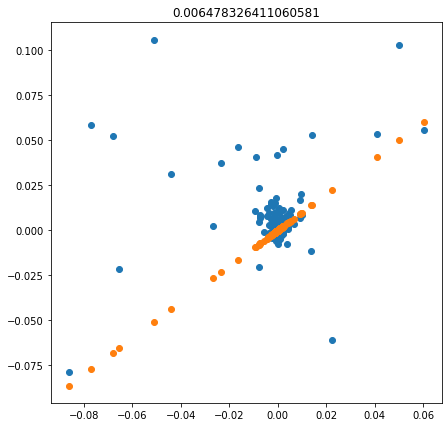

In [24]:
plt.scatter(
    (test_losses_no_1 - test_losses).cpu()[indices],
    _pred_influences[indices])
plt.title(
    pearsonr(
    (test_losses_no_1 - test_losses).cpu()[indices],
    _pred_influences[indices])[0])
plt.scatter((test_losses_no_1 - test_losses).cpu()[indices],
            (test_losses_no_1 - test_losses).cpu()[indices])